In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from joblib import Parallel, delayed
from matplotlib.ticker import FormatStrFormatter

In [3]:
def save_plot(fig, pltname, artists=(), size_inches=(4,4)):
    fig.set_size_inches(size_inches)
    fig.savefig(os.path.join("..", "figures", "permutation_tests_tree_" + pltname + ".png"), dpi=300, bbox_extra_artists=artists, bbox_inches='tight')

In [4]:
# Load up the mapping file
df_mapping = pd.read_csv("../data/SampleID_map.txt", sep='\t', index_col=0)
df_mapping.head()

,UserName,StudyDayNo,StudyDate,Gender,Age,Weight,Height,BMI,Supplement,Waist.Circumference,...,fecal.time,BMI.1,Weight.Change,Plate,SampleOrder,SampleType,Timing,Activity.Factor,Medications,Dietary.Supp
#SampleID,,,,,,,,,,,,,,,,,,,,,
Blank.A02.,Blank_A02,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,Blank,NaN,NaN,NaN,NaN
Blank.A03.,Blank_A03,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,Blank,NaN,NaN,NaN,NaN
Blank.A04.,Blank_A04,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,Blank,NaN,NaN,NaN,NaN
Blank.A07.,Blank_A07,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,NaN,Blank,NaN,NaN,NaN,NaN
Blank.B12.,Blank_B12,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,Blank,NaN,NaN,NaN,NaN


In [5]:
# Load up the distance matrix
df_distance = pd.read_csv("../data/buttiques.dm.txt", sep=' ', index_col=None)
# Reflect lower triangle to upper triangle
#for i in range(df_distance.shape[0]):
#    for j in range(i, df_distance.shape[1]):
#        df_distance.iloc[i, j] = df_distance.iloc[j, i]
# Why are some values greater than 100?
#print(np.sum(df_distance.values <= 100, axis=1))

#df_distance.values[df_distance.values >= 100] = df_distance.values[df_distance.values >= 100] - 100
df_distance.columns = df_distance.index
df_distance.head()

,MCT.f.0187,MCT.f.0186,MCT.f.0185,MCT.f.0183,MCT.f.0176,MCT.f.0173,MCT.f.0180,MCT.f.0174,MCT.f.0171,MCT.f.0172,...,MCT.f.0593,MCT.f.0579,MCT.f.0585,MCT.f.0586,MCT.f.0587,MCT.f.0581,MCT.f.0580,MCT.f.0582,MCT.f.0592,MCT.f.0590
MCT.f.0187,0.00000,2.44516,2.43706,2.40814,2.47953,2.46072,2.57432,2.58551,2.39018,2.35707,...,2.98129,2.98894,2.98254,3.04049,3.07848,3.07606,3.07938,3.21168,3.08105,2.96410
MCT.f.0186,2.44516,0.00000,2.25576,2.24940,2.35537,2.33656,2.45016,2.46135,2.26602,2.23291,...,2.85713,2.86478,2.85838,2.91633,2.95432,2.95190,2.95522,3.08752,2.95689,2.83994
MCT.f.0185,2.43706,2.25576,0.00000,2.24130,2.34727,2.32846,2.44206,2.45325,2.25792,2.22481,...,2.84903,2.85668,2.85028,2.90823,2.94622,2.94380,2.94712,3.07942,2.94879,2.83184
MCT.f.0183,2.40814,2.24940,2.24130,0.00000,2.31835,2.29954,2.41314,2.42433,2.22900,2.19589,...,2.82011,2.82776,2.82136,2.87931,2.91730,2.91488,2.91820,3.05050,2.91987,2.80292
MCT.f.0176,2.47953,2.35537,2.34727,2.31835,0.00000,2.28581,2.39941,2.41060,2.21527,2.18216,...,2.84612,2.85377,2.84737,2.90532,2.94331,2.94089,2.94421,3.07651,2.94588,2.82893


In [6]:
# summary statistic
def difference_of_stats(samples, df_distance):
    s = 0.
    for i in range(len(samples)-1):
        s += df_distance[samples[i]][samples[i+1]]
    return s

In [7]:
NUM_PERMUTATIONS = 100000
statistics_original = dict()
statistics_permuted = dict()

# Retrieve a vector sample numbers, in order of date
for group, df in df_mapping.groupby('UserName'):
    if 'Blank' not in group:
        df = df.sort_values('StudyDayNo')
        # Remove samples not in akronymer
        df = df[[_ in df_distance.index for _ in df.index]]
        # Verify after filter there are more than 1 sample
        if df.shape[0] > 1:
            diff = np.diff(df['StudyDayNo']) == 1
            # Double the first value for indexing
            diff = np.insert(diff, 0, diff[0], axis=0)
            df = df[diff]
            # Verify after filter there are more than 1 sample
            if df.shape[0] > 1:
                statistics_permuted[group] = np.zeros(NUM_PERMUTATIONS)
                statistics_original[group] = difference_of_stats(df.index, df_distance)
                for i in range(NUM_PERMUTATIONS):
                    x = np.array(df.index)
                    np.random.shuffle(x)
                    statistics_permuted[group][i] = difference_of_stats(x, df_distance)

In [8]:
# Flatten the dictionaries
flattened_statistics_original = np.zeros(len(statistics_permuted.keys()))
for i, (key, value) in enumerate(statistics_original.items()):
    flattened_statistics_original[i] = value

# Flatten the 
flattened_statistics_permuted = np.zeros((len(statistics_permuted.keys()), NUM_PERMUTATIONS))
for i, (key, value) in enumerate(statistics_permuted.items()):
    flattened_statistics_permuted[i, :] = value

In [9]:
# Check for significance of order
print((np.sum(flattened_statistics_original.sum() >= flattened_statistics_permuted.sum(axis=0))/(NUM_PERMUTATIONS+1)))

0.0378696213038


In [10]:
flattened_statistics_permuted.sum(axis=0)

array([ 802.83721,  805.69188,  804.68019, ...,  803.95223,  801.67506,
        803.43872])

In [11]:
flattened_statistics_original.sum()

801.27672999999993

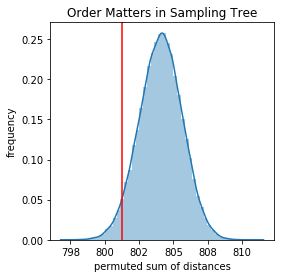

In [12]:
fig, ax = plt.subplots()
sns.distplot(flattened_statistics_permuted.sum(axis=0), ax=ax)
plt.axvline(x=flattened_statistics_original.sum(), color='red')
ax.set_ylabel('frequency')
ax.set_xlabel('permuted sum of distances')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_title('Order Matters in Sampling Tree')
#ax.set_xlim(flattened_statistics_original.sum()-1, flattened_statistics_permuted.sum(axis=0).max()+1)
save_plot(fig, 'ordermatters_hist')

In [ ]:
df_filter_blanks = df_mapping[['Blank' not in _ for _ in df_mapping['UserName']]]

df_filter_blanks = df_filter_blanks.reindex(df_distance.index)

groups_filter = set()
for group, df in df_filter_blanks.groupby('UserName'):
    # Remove samples not in akronymer
    df = df[[_ in df_distance.index for _ in df.index]]
    # Verify after filter there are more than 1 sample        
    if df.shape[0] <= 1:
        groups_filter.add(group)

df_filter_blanks = df_filter_blanks[[_ not in groups_filter for _ in df_filter_blanks['UserName']]]

In [ ]:
NUM_PERMUTATIONS = 10000

statistic_original = 0.
for group, df in df_filter_blanks.groupby('UserName'):
    statistic_original += df_distance.loc[df.index, df.index].sum().sum()/2
    
def permute_statistic(df_filter_blanks, df_distance):
    df_filter_blanks['UserName'] = np.random.permutation(df_filter_blanks['UserName'])
    s = 0.
    for group, df in df_filter_blanks.groupby('UserName'):
        s += df_distance.loc[df.index, df.index].sum().sum()/2
    return s

statistics_permuted = Parallel(n_jobs=-1)(delayed(permute_statistic)(df_filter_blanks, df_distance) for _ in range(NUM_PERMUTATIONS))
statistics_permuted = np.array(statistics_permuted)   

In [30]:
# Check for significance of order
print((np.sum(statistic_original >= statistics_permuted)+1)/(NUM_PERMUTATIONS+1.))

9.99900009999e-05


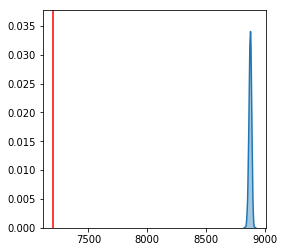

In [29]:
# Retrieve a vector sample numbers, in order of date
fig, ax = plt.subplots()
sns.distplot(statistics_permuted, ax=ax)
plt.axvline(x=statistic_original, color='red')
#ax.set_xlim(statistic_original-1, statistics_permuted.max()+1)
save_plot(fig, 'personmatters_hist')